# Notebook for Programming in Problem 4
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement a sequence-to-sequence (seq2seq) transformer model to build a nerual machine translation (NMT) system, which translates from French to English.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
You can edit code in the other parts of the notebook too, which can be useful for debugging, but be careful to avoid breaking the provided code.

## Installing Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.
In addition, we will also be needing [huggingface](https://huggingface.co/)'s `transformers` and `datasets` libraries, and [nltk](https://www.nltk.org/) to compute the BLEU score.

In [1]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.0 which is incompatible.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other require

## Download NMT data

We first download the data for NMT, which contains pairs of parallel sentences.

In [2]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip


In [3]:
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.10.0
    Uninstalling datasets-2.10.0:
      Successfully uninstalled datasets-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.0 which is incompatible.


## Data preprocessing
In this section we will write code to load and tokenize the data for NMT.


The parallel data is provided as huggingface datasets, one for each split of `train`, `validation` and `test`. We load it via the `load_from_disk` method and inspect its features. If you'd like to know more about these dataset objects, have a look at [this tutorial](https://huggingface.co/docs/datasets/access).

In [4]:
from datasets import load_from_disk

# Load the dataset from disk
raw_text_datasets = load_from_disk("resources/parallel_en_fr_corpus")
# Print a summary of the splits and preview the first 10 examples
print("Summary of splits:", raw_text_datasets)
for i in range(10):
    print(f"Training example {i + 1}: {raw_text_datasets['train'][i]}")


Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})
Training example 1: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}
Training example 2: {'text_en': 'i m not in a rush .', 'text_fr': 'je ne suis pas aux pieces .'}
Training example 3: {'text_en': 'i m not sleeping well .', 'text_fr': 'je ne dors pas bien .'}
Training example 4: {'text_en': 'he s my partner .', 'text_fr': 'c est mon associe .'}
Training example 5: {'text_en': 'you re silly .', 'text_fr': 'tu es idiote .'}
Training example 6: {'text_en': 'we re committed .', 'text_fr': 'nous sommes engagees .'}
Training example 7: {'text_en': 'you re the reason i came .', 'text_fr': 'c est pour vous que je suis venu .'}
Training example 8: {'text_en': 'she is a child 

You are also provided with two pre-trained tokenizers for the source and target languages respectively, which we can load with the hugginface transfomers library. [This tutorial](https://huggingface.co/docs/transformers/preprocessing#natural-language-processing) provides an introduction to using pre-trained tokenizers and the powerful `AutoTokenizer` class. The tokenizers are based on byte-pair encodings which break words into smaller units. This is aimed at reducing the sparsity of words, as subwords can be shared between different rare words. If you are interested in learning more, see the paper [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162.pdf).

In [5]:
#device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
from transformers import AutoTokenizer

# Load tokenizers for the source (French) and target (English) languages
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")

# Print the vocabulary sizes of the tokenizers
print("Vocab size of source language:", source_tokenizer.vocab_size)
print("Vocab size of target language:", target_tokenizer.vocab_size)


Vocab size of source language: 3200
Vocab size of target language: 3200


In [7]:
# Demonstration with an example sentence in English
example_sentence = "we have an example"
tokenizer_output = target_tokenizer(example_sentence)

# Print the tokenized sentence and the decoded tokens
print("\n*** Example ***")
print("Example sentence:", example_sentence)
print("Tokenizer output:", tokenizer_output)

# Convert token IDs to strings and decode special tokens (like ▁)
decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("Tokens:", decoded_sequence)

# Reconstruct the sentence with some modifications (remove special characters like ▁)
reconstructed = "".join(decoded_sequence).replace("▁", " ")
print("Reconstructed sentence:", reconstructed)



*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
Reconstructed sentence: <s> we have an example</s>


We now want to convert the entire dataset to token ids.
Specifically, we want to use the tokenizers to create a dataset with
features "encoder_input_ids" and "decoder_input_ids", which both have type `List[int]`
and which will later be the inputs to our encoder-decoder model. We will implement this using the powerful `map` function. You can find its API reference [here](https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset.map).

In [8]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # Tokenize the source text in French and the target text in English
    encoder_input_ids = source_tokenizer(example["text_fr"], truncation=True, padding="max_length")["input_ids"]
    decoder_input_ids = target_tokenizer(example["text_en"], truncation=True, padding="max_length")["input_ids"]

    return {"encoder_input_ids": encoder_input_ids, "decoder_input_ids": decoder_input_ids}

# Apply the map function to each split of the dataset
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)

# Remove the original text columns
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])


Map:   0%|          | 0/8701 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

## Transformer model for NMT

We will now implement a encoder-decoder transformer model.
We already provide code for the Feedforward Layers and Transformer Blocks, but you will have to implement the MultiHeadAttention and Embedding layer from scratch, as well as registering all the layers in the final EncoderDecoderModel. Pay attention to doc-strings and typing information to understand the context and purpose of each missing code block!

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [10]:
import torch
import torch.nn as nn
from typing import Optional, Tuple

class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        super().__init__()
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."
        self.hidden_size = hidden_size

        self.num_heads = num_attention_heads
        self.head_dim = hidden_size // num_attention_heads

        self.is_causal_attention = is_causal_attention
        self.is_cross_attention = is_cross_attention

        # Projection layers for query, key, and value
        self.query_proj = nn.Linear(hidden_size, hidden_size,bias=False) #to transform the input enbeddings to Q matrix
        self.key_proj = nn.Linear(hidden_size, hidden_size,bias=False)  #to transform the input enbeddings to K matrix
        self.value_proj = nn.Linear(hidden_size, hidden_size,bias=False)  #to transform the input enbeddings to V matrix
        # Output projection
        self.out_proj = nn.Linear(hidden_size, hidden_size,bias=False)



    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        """Creates a causal mask for preventing attention to future tokens."""
        mask = torch.triu(torch.full((sequence_length, sequence_length), -1e8), diagonal=1)

        #Add 1,1 dimensions to beginning and move to device
        return mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, seq_len, seq_len)

    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:#Get Device (Assuming hidden_states tensor is on correct device)
          device = hidden_states.device

          #Get Dimensions
          batch_size = hidden_states.shape[0]
          seq_length = hidden_states.shape[1]


          # Calculate Q, K, V
          queries = self.query_proj(hidden_states) # Shape : (batch_size, sequence_length, hidden_size)

          if self.is_cross_attention:
            values = self.value_proj(encoder_outputs) # Shape : (batch_size, sequence_length, hidden_size)
            keys = self.key_proj(encoder_outputs) # Shape : (batch_size, sequence_length, hidden_size)
            seq_length2 = encoder_outputs.shape[1] # In case of cross attention it will be the encoder's sequence length
          else:
            values = self.value_proj(hidden_states) # Shape : (batch_size, sequence_length, hidden_size)
            keys = self.key_proj(hidden_states) # Shape : (batch_size, sequence_length, hidden_size)
            seq_length2 = seq_length # If no cross attention is used will be same as sequence length


          # Add New Axis for attention heads (Change last dimension from hidden_size to num_heads x head_dim)
          #Each head in multihead attention gets a part of the embedding for each word in the sentence
          queries =  queries.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
          values = values.reshape(batch_size, seq_length2, self.num_heads, self.head_dim)
          keys = keys.reshape(batch_size, seq_length2, self.num_heads, self.head_dim)


          # Change dimensions from: (batch_size, seq_length/seq_length2, num_heads, head_dim) to (batch_size, num_heads, seq_length/seq_length2, head_dim)
          # Transpose Dimension 1 and Dimension 2
          queries = queries.transpose(1,2) # Shape : (batch_size, num_heads, seq_length, head_dim)
          values = values.transpose(1,2) # Shape : (batch_size, num_heads, seq_length2, head_dim)
          keys = keys.transpose(1,2) # Shape : (batch_size, num_heads, seq_length2, head_dim)

          #For keys, we need to also swap seq_length2 and head_dim for the bmm for the attention scores
          keys = keys.transpose(2, 3) # Shape : (batch_size, num_heads, head_dim, seq_length2)

          #Calculate Attention Scores
          attention_scores = torch.matmul(queries, keys) / math.sqrt(self.head_dim) # (batch_size, num_heads, seq_length, seq_length2)


          #Apply causal Mask
          if self.is_causal_attention:
            causal_mask = self.causal_attention_mask(seq_length, device)
            attention_scores += causal_mask

          #Apply Padding Mask
          '''
          1- key_padding_mask has shape: (batch_size, seq_length2).
          2- Convert to float (True/False) -> (1.0/0.0)
          3- Multiply by 1e-6. (1.0/0.0) -> (-1e6/0.0) -1e6 where padding tokens are
          4- Then we reshape it to be: (batch_size, 1, 1, seq_length2)
          5- Which is broadcastable to: (batch_size, num_heads, seq_length, seq_length2) for attention_scores

          '''
          key_padding_mask = key_padding_mask.to(torch.float) * -1e6 # 1e-6 where pad = True and 0 where pad = False
          key_padding_mask = key_padding_mask.reshape(batch_size, 1, 1, seq_length2)
          attention_scores += key_padding_mask


          # Apply Softmax to last dimension
          attention_scores = torch.nn.functional.softmax(attention_scores, dim=-1) # Shape: (batch_size, num_heads, seq_length, seq_length2)


          # Multiply by value vectors and add
          '''
          Attention Scores: (batch_size, num_heads, seq_length, seq_length2)
          Values Vectors: (batch_size, num_heads, seq_length2, head_dim)
          BMM Result: (batch_size, num_heads, seq_length, head_dim)
          '''

          attention_outputs = torch.matmul(attention_scores, values) # (batch_size, num_heads, seq_length, head_dim)

          '''
          For attention weights:
          Convert (batch_size, num_heads, seq_length, head_dim) to (batch_size, seq_length, num_heads, head_dim) by transposing
          Then reshape to be: (batch_size, seq_length, num_heads * head_dim) = (batch_size, seq_length, hidden_size)
          '''
          attention_outputs = attention_outputs.transpose(1, 2)
          attention_outputs = attention_outputs.reshape(batch_size, seq_length, self.hidden_size)


          # Multiply Attention Outputs with output matrix
          attention_outputs = self.out_proj(attention_outputs) # (batch_size, num_heads, seq_length, head_dim)


          return (attention_outputs, attention_scores)


Before we move on to the other modules, you should implement a sanity check for your attention implementation:
1. We check the dimensions of the output of the layer and
2. We plot the attention weights to some toy embedding inputs.
We assume that the last token in the encoder and the last two tokens in the decoder are pad tokens.

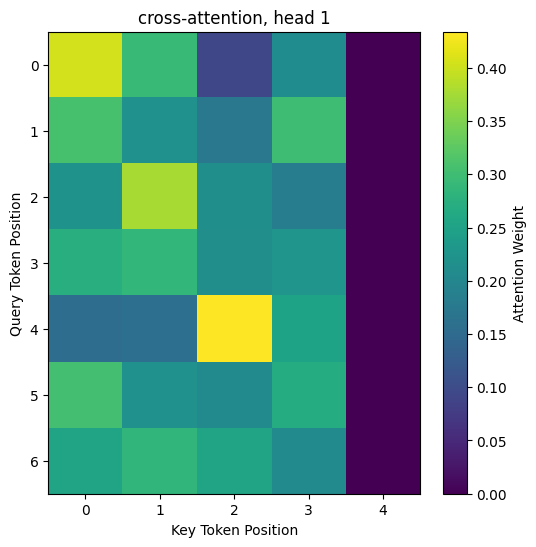

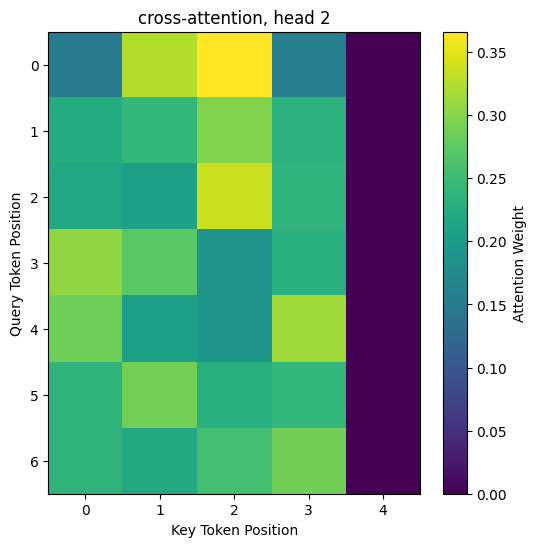

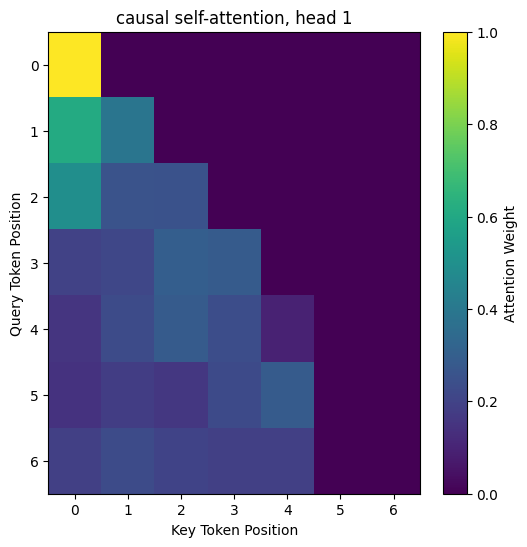

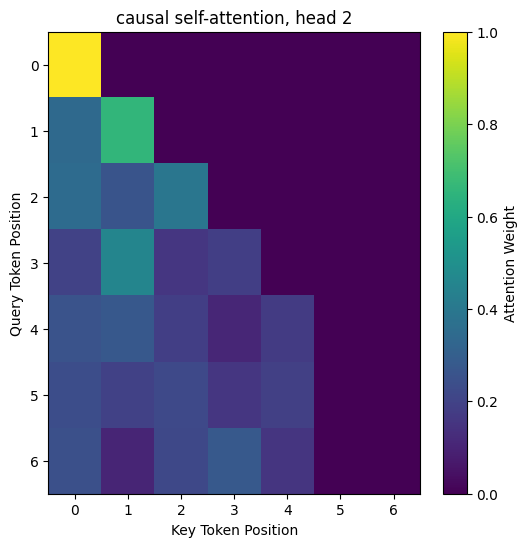

In [11]:
embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True # The last encoder token is a padding tokens

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True # The last two decoder tokens are padding token


cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)

cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Make sure your outputs have the right hapes
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

# Check that the attention weights are normalized
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()


import matplotlib.pyplot as plt

def plot_attention_matrix(attention_matrix, title):
    """Creates a new figure and plots the normalized attention weights as a heatmap.

    This should provide a colorbar for the scale of the heatmap and label the axes "query token position" and "key token position".
    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    # TODO Implement this function
    plt.figure(figsize=(6, 6))
    plt.imshow(attention_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Attention Weight')
    plt.xlabel("Key Token Position")
    plt.ylabel("Query Token Position")
    plt.title(title)
    plt.show()

    #raise NotImplementedError("Plotting the attention weights is not implemented yet.")

plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "causal self-attention, head 2")

In [12]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                    used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                    used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()

        # TODO Initialize the module and its parameters here.
        # You should use `nn.Embedding` for both token embeddings and positional embeddings
        self.embeddings=nn.Embedding(vocab_size,hidden_size)
        self.posEmbeddings=nn.Embedding(max_sequence_length,hidden_size)#learnt postional embedding

        #raise NotImplementedError("The __init__ function in TransformerEmbeddings is not implemented yet.")

    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """

        # TODO Implement this function
        # Hint: you can access the weight parameter matrix via .weight of an nn.Embedding module:
        # Example:
        # ```embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # assert list(embeddings.weight.shape) == [num_embeddings, embedding_dim]```
        # torch.matmul or F.linear may also be useful here.
        self.logits = torch.matmul(decoder_output, self.embeddings.weight.T)
        return self.logits

       # raise NotImplementedError("The compute_logits function in TransformerEmbeddings is not implemented yet.")

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """

        # TODO Implement the forward pass of the embedding layer.
        # IMPORTANT: For full credit, you should not use python loops!
        #myEmbeddings=self.embeddings(input_ids)#shape (batchsize,sequenceLength,demb)
        #posEmbeddings=self.posEmbeddings(torch.arange(input_ids.shape[1]))#get positional embedding to each word shape(batchsize,sequence_length,demb)
        #return myEmbeddings+posEmbeddings
        # Compute token embeddings
        token_embeddings = self.embeddings(input_ids)#(batch_size, sequence_length, hidden_size)
        # Compute position embeddings
        batch_size, sequence_length = input_ids.shape
        position_ids = torch.arange(sequence_length, dtype=torch.int, device=input_ids.device)#[0 to sequence length]
        # device=input_ids.device ensures that output tensor on the same oricessor as inputs_id
        position_ids = position_ids.unsqueeze(0).expand(batch_size, sequence_length)#change tensor size to (batchSize,sequence length)
        position_embeddings = self.posEmbeddings(position_ids)

        # Sum token embeddings and position embeddings
        embeddings = token_embeddings + position_embeddings  #badel el plus be concat w zabat ba2eet el code fel dim

        return embeddings


        #raise NotImplementedError("The forward function in TransformerEmbeddings is not implemented yet.")


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.LeakyReLU(),
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(intermediate_size, hidden_size)





        )
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        Returns:
            The output tensor after applying self-attention, (optional) cross-attention, and feedforward layers.
        """
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states



In [29]:
import torch
import torch.nn as nn
import math

class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """
        super().__init__()
        # TODO Register the input embedding modules and the encoder and decoder blocks.
        # You should use the TransformerBlock and TransformerEmbeddings sub-modules.
        self.hidden_size=hidden_size

        self.num_encoder_layers=num_encoder_layers
        self.num_decoder_layers=num_decoder_layers
        self.max_sequence_length=max_sequence_length
        self.source_vocab_size=source_vocab_size
        self.target_vocab_size=target_vocab_size
        self.linear=nn.Linear(self.hidden_size, self.target_vocab_size,bias=False)#WO layer to conver output back
        self.source_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        self.target_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)
        self.encoderlayers = nn.ModuleList([TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob) for _ in range(self.num_encoder_layers)])
        self.decoderlayers = nn.ModuleList([TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=True) for _ in range(self.num_decoder_layers)])
        # Hint: Check out `nn.ModuleList` to register a variable number of sub-modules.

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """
        # Generate position ids for input sequences (broadcasted across batch)
        embd = self.source_embeddings(input_ids)
        for layer in self.encoderlayers:
          embd=layer(embd,padding_mask)#pass output of each encoder to the next encoder
        return (embd)

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocab_size)
            containing the logits for predicting the next token in the target sequence.
        """

        embd = self.target_embeddings(input_ids)
        for layer in self.decoderlayers:
          embd=layer(embd,padding_mask,encoder_outputs,encoder_padding_mask)#pass output of each decoders to the next decoder

        return self.target_embeddings.compute_logits(embd)

        #raise NotImplementedError("The forward_decoder function has to be implemented.")

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)
        return decoder_logits

## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.
Before you start training models, you should implement and test the model and its sub-modules, especially the attention.

First, we implement a `collate` function, which takes a list of examples from the dataset and forms a batch,
consisting of padded encoder and decoder input ids, as well as encoder and decoder padding masks.

In [30]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    for i, example in enumerate(examples):
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

Next, we provide a simple training loop.

In [31]:
import time
import math

def compute_loss_per_token(model, batch):
    logits = model(**batch)

    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]

    return F.cross_entropy(logits, labels, reduction='none')


def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for batch in dev_loader:
            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl


def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('-10e6')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')


    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()

            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size
            loss.backward()

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

Let's train a relatively small model architecture for 15 epochs.
With a reasonable implementation, this should take about 16 minutes on CPU / 3 minutes on GPU and we should achieve a validation perplexity of below 10!

In [50]:
# Set a random seed, so you obtain the same output model if you run this cell again.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,

    # Increase hidden size to capture more complex patterns
    hidden_size=128,

    # Keep the intermediate size proportional to hidden size
    intermediate_size=128 * 4,  # Increased to 512

    # Increase attention heads to allow the model to focus on more parts of the input
    num_attention_heads=16,

    # Increase number of encoder and decoder layers to better model complex relationships
    num_encoder_layers=6,

    num_decoder_layers=6,

    # Increase maximum sequence length for handling longer sentences
    max_sequence_length=32,

    # Adjust dropout rate to 0.2 for better regularization
    hidden_dropout_prob=0.3,
)



print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=20, model_path="model.pt")

Model architecture: EncoderDecoderModel(
  (linear): Linear(in_features=128, out_features=3200, bias=False)
  (source_embeddings): TransformerEmbeddings(
    (embeddings): Embedding(3200, 128)
    (posEmbeddings): Embedding(32, 128)
  )
  (target_embeddings): TransformerEmbeddings(
    (embeddings): Embedding(3200, 128)
    (posEmbeddings): Embedding(32, 128)
  )
  (encoderlayers): ModuleList(
    (0-5): 6 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (query_proj): Linear(in_features=128, out_features=128, bias=False)
        (key_proj): Linear(in_features=128, out_features=128, bias=False)
        (value_proj): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (self_attention_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): LeakyReLU(negativ

## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

In [51]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0) # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool) # No padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0) # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool) # No padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs)

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]

            if new_completed_scores.max() > best_score:
                best_score = new_completed_scores.max()
                best_generation = new_completed_generations[new_completed_scores.argmax()]

        if best_score >= new_scores.max():
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0]

    return best_generation, best_score.cpu().item()


def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)


    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [52]:
# Restore the best validation checkpoint
#model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

Use device: cuda:0


100%|██████████| 486/486 [02:06<00:00,  3.84it/s]



Corpus BLEU: 62.70859616178567


Let's look at some examples. What do you think of the quality of the translations?

In [53]:
# Feel free to change the range to look at more samples!
for k in range(1, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 1 =====
Input:  je ne suis pas malheureux .
Gold:  i m not miserable .
Pred:  i m not surprised .
===== Sample 2 =====
Input:  je vais prendre ma voiture .
Gold:  i m going to take my car .
Pred:  i m going to be car .
===== Sample 3 =====
Input:  il adore les chats .
Gold:  he s a cat lover .
Pred:  he s very danger .
===== Sample 4 =====
Input:  j en suis contente .
Gold:  i m happy with that .
Pred:  i m happy with it .
===== Sample 5 =====
Input:  ils sont en dessous .
Gold:  they re downstairs .
Pred:  they re downstairs .
===== Sample 6 =====
Input:  je ne suis pas ton ennemi .
Gold:  i am not your enemy .
Pred:  i am not your enemy .
===== Sample 7 =====
Input:  il n est pas idiot .
Gold:  he is not stupid .
Pred:  he s not stupid .
===== Sample 8 =====
Input:  elles ont la frousse .
Gold:  they re jittery .
Pred:  they re jittery .
===== Sample 9 =====
Input:  je ne suis pas celle que tu penses .
Gold:  i m not who you think i am .
Pred:  i m not who you think i am

# Questions

Please answer written questions from the assignment in this section. You can alter the provided code to obtain the answers, but be careful not to break anything!

**(b) (4 points)**

- (i)
    What vocabulary size are we using for the source and target language?

- (ii)
    Approximately how many source and target tokens are on average contained in a training batch? What proportion of these tokens are `<pad>` tokens on average?

- (iii)
What is the specific purpose of saving the model parameters in a file `model.pt` throughout training in the code we provide?

**(c) (2 points)**
Manually look at some results and compare them with the gold answers. What do you think of the quality of the translations? Are these grammatical English sentences? Can you identify any common mistakes?

**(d) (4 points)**
Consider the provided beam search method. This implementation is not efficient and performs a lot of repeated computation. Identify the issue and propose how you can fix it.
In particular, describe how would you have to change the arguments and return values of your EncoderDecoderModel and its sub-modules?